### Project Goal:
To build a gender and age detector that can approximately guess the gender and age of the person (face) in a picture.
The dataset used is the UTKFace dataset which is a large-scale face dataset consisting of over 20,000 images. The images cover a wide range of ages and races and include both males and females.

### Import Libraries & Packages

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import argparse
import sys
import json
import os

import cv2
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Input
from keras_applications.resnext import ResNeXt50
from keras.utils.data_utils import get_file
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense,MaxPool2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

#### Load dataset

In [13]:
path='Dataset/UTKFace/'
images=[]
ages=[]
genders=[]

for file in os.listdir(path):
    age=file.split('_')[0]
    gender=file.split('_')[1]
    image=cv2.imread(path+file,0)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    images.append(np.array(image))
    ages.append(np.array(age))
    genders.append(np.array(gender))

Gender :  0 Age :  14


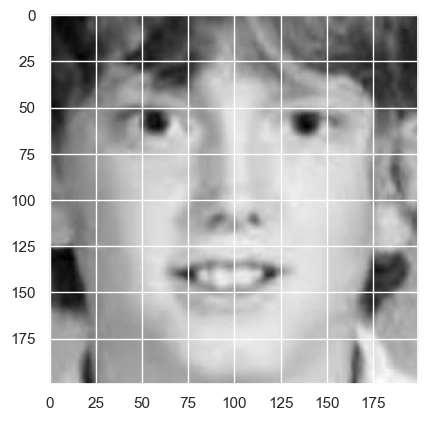

In [14]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show

s_img=images[500]
print("Gender : ",genders[500],"Age : ",ages[500])

display(s_img)

In [15]:
df=pd.DataFrame()
df['Images'],df['Age'],df['Gender']=images,ages,genders
df.head()

,Images,Age,Gender
0,"[[[208, 208, 208], [206, 206, 206], [205, 205,...",100,0
1,"[[[122, 122, 122], [124, 124, 124], [126, 126,...",100,0
2,"[[[222, 222, 222], [235, 235, 235], [236, 236,...",100,1
3,"[[[82, 82, 82], [82, 82, 82], [82, 82, 82], [8...",100,1
4,"[[[69, 69, 69], [70, 70, 70], [71, 71, 71], [7...",100,1


C:\Users\Durga P T M\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

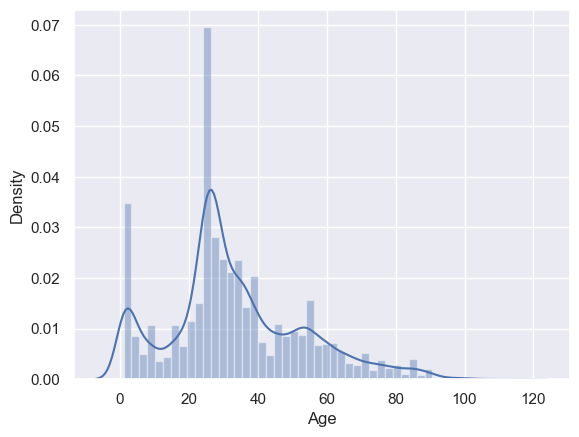

In [16]:
sns.set_theme()
sns.distplot(df['Age'])

In [18]:
files=os.listdir(path)
features=np.zeros((len(files),s_img.shape[0],s_img.shape[1],1),dtype='float32')
features=features/255

In [29]:
ages=np.array(ages,dtype=np.int64)
images = np.array(images) 
genders=np.array(genders,np.int64)

In [38]:
x_train_age,x_test_age,y_train_age,y_test_age=train_test_split(images,ages,random_state=42)

x_train_gender,x_test_gender,y_train_gender,y_test_gender=train_test_split(images,genders,random_state=42)

### Define age model and train

In [31]:
age_model=Sequential()
age_model.add(Conv2D(128,kernel_size=3,activation='relu',input_shape=(200,200,3)))
age_model.add(MaxPool2D(pool_size=3,strides=2))

age_model.add(Conv2D(128,kernel_size=3,activation='relu'))
age_model.add(MaxPool2D(pool_size=3,strides=2))

age_model.add(Conv2D(256,kernel_size=3,activation='relu',input_shape=(200,200,3)))
age_model.add(MaxPool2D(pool_size=3,strides=2))

age_model.add(Conv2D(512,kernel_size=3,activation='relu',input_shape=(200,200,3)))
age_model.add(MaxPool2D(pool_size=3,strides=2))

age_model.add(Flatten())
age_model.add(Dropout(0.2))
age_model.add(Dense(512,activation='relu'))

age_model.add(Dense(1,activation='linear',name='ages'))

age_model.compile(optimizer='adam',loss='mse',metrics=['mae'])
age_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 198, 198, 128)     3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 98, 98, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 96, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 47, 47, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 22, 22, 256)     

In [32]:
history_age=age_model.fit(x_train_age,y_train_age,validation_data=(x_test_age,y_test_age),epochs=10)

Epoch 1/10
556/556 [==============================] - 5286s 9s/step - loss: 34930.0977 - mae: 23.2352 - val_loss: 242.8002 - val_mae: 11.8029
Epoch 2/10
556/556 [==============================] - 3502s 6s/step - loss: 245.8578 - mae: 11.9066 - val_loss: 191.2377 - val_mae: 10.4022
Epoch 3/10
556/556 [==============================] - 3545s 6s/step - loss: 200.6171 - mae: 10.6006 - val_loss: 166.2097 - val_mae: 9.6982
Epoch 4/10
556/556 [==============================] - 3559s 6s/step - loss: 171.6385 - mae: 9.7833 - val_loss: 140.9611 - val_mae: 8.7189
Epoch 5/10
556/556 [==============================] - 50058s 90s/step - loss: 148.9597 - mae: 9.0651 - val_loss: 182.2439 - val_mae: 9.6543
Epoch 6/10
556/556 [==============================] - 7517s 14s/step - loss: 140.8972 - mae: 8.8073 - val_loss: 129.8253 - val_mae: 8.6041
Epoch 7/10
556/556 [==============================] - 3640s 7s/step - loss: 126.0322 - mae: 8.3470 - val_loss: 126.0365 - val_mae: 8.3365
Epoch 8/10
556/556 [====

### Define gender model and train

In [41]:
gender_model=Sequential()
gender_model.add(Conv2D(36,kernel_size=3,activation='relu',input_shape=(200,200,3)))
gender_model.add(MaxPool2D(pool_size=3,strides=2))

gender_model.add(Conv2D(64,kernel_size=3,activation='relu'))
gender_model.add(MaxPool2D(pool_size=3,strides=2))

gender_model.add(Conv2D(128,kernel_size=3,activation='relu'))
gender_model.add(MaxPool2D(pool_size=3,strides=2))

gender_model.add(Conv2D(256,kernel_size=3,activation='relu'))
gender_model.add(MaxPool2D(pool_size=3,strides=2))

gender_model.add(Conv2D(512,kernel_size=3,activation='relu'))
gender_model.add(MaxPool2D(pool_size=3,strides=2))

gender_model.add(Flatten())
gender_model.add(Dropout(0.2))
gender_model.add(Dense(512,activation='relu'))

gender_model.add(Dense(1,activation='sigmoid',name='gender'))

gender_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
gender_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 198, 198, 36)      1008      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 98, 98, 36)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 96, 96, 64)        20800     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 47, 47, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 22, 22, 128)     

In [42]:
history_gender=gender_model.fit(x_train_gender,y_train_gender,validation_data=(x_test_gender,y_test_gender),epochs=5)

Epoch 1/5
556/556 [==============================] - 1068s 2s/step - loss: 1.1582 - accuracy: 0.7243 - val_loss: 0.4918 - val_accuracy: 0.7547
Epoch 2/5
556/556 [==============================] - 1043s 2s/step - loss: 0.4227 - accuracy: 0.8057 - val_loss: 0.3712 - val_accuracy: 0.8264
Epoch 3/5
556/556 [==============================] - 1029s 2s/step - loss: 0.3616 - accuracy: 0.8388 - val_loss: 0.3437 - val_accuracy: 0.8441
Epoch 4/5
556/556 [==============================] - 1033s 2s/step - loss: 0.3363 - accuracy: 0.8505 - val_loss: 0.3320 - val_accuracy: 0.8573
Epoch 5/5
556/556 [==============================] - 1046s 2s/step - loss: 0.3150 - accuracy: 0.8587 - val_loss: 0.3059 - val_accuracy: 0.8623


### Plotting the validation loss vs training loss for age models

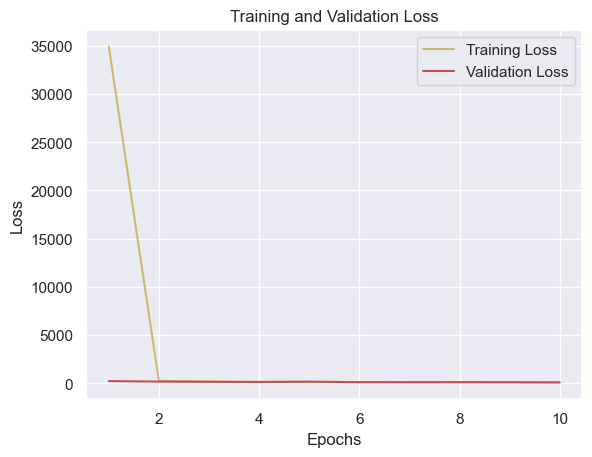

In [44]:
loss=history_age.history['loss']
val_loss=history_age.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plotting the validation accuracy vs training accuracy for age models

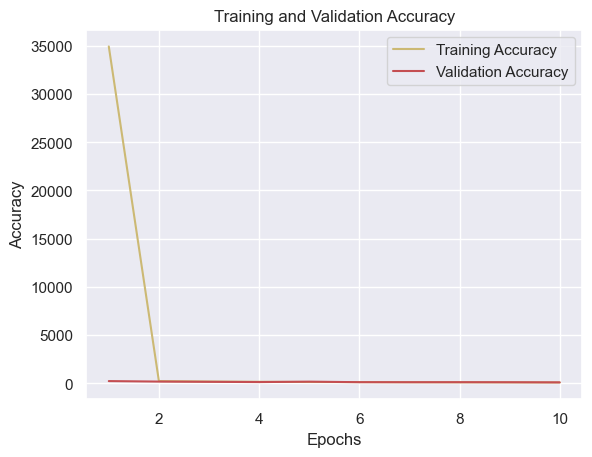

In [45]:
acc=history_age.history['loss']
val_acc=history_age.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()